In [7]:
from ilms.data import get_celeba_arrays

In [8]:
# train, _, _,_,_,_ = get_celeba_arrays("/work3/s210527/data/celeba_manual/celeba/")
train, _, _,_,_,_ = get_celeba_arrays("/data/celeba/")

In [9]:
train.shape

(162770, 64, 64, 3)

In [10]:
train[0]

array([[[0.9843137 , 0.92941177, 0.79607844],
        [0.9843137 , 0.93333334, 0.8       ],
        [0.9882353 , 0.9372549 , 0.8039216 ],
        ...,
        [0.4117647 , 0.21568628, 0.11764706],
        [0.4509804 , 0.25490198, 0.14117648],
        [0.6392157 , 0.47843137, 0.3254902 ]],

       [[0.99215686, 0.9372549 , 0.80784315],
        [0.9843137 , 0.93333334, 0.8039216 ],
        [0.9882353 , 0.9372549 , 0.80784315],
        ...,
        [0.39215687, 0.19215687, 0.09803922],
        [0.5058824 , 0.30980393, 0.1882353 ],
        [0.64705884, 0.5058824 , 0.30980393]],

       [[0.9882353 , 0.93333334, 0.80784315],
        [0.9882353 , 0.9372549 , 0.8117647 ],
        [0.9882353 , 0.9372549 , 0.8117647 ],
        ...,
        [0.49803922, 0.30980393, 0.21960784],
        [0.49803922, 0.3137255 , 0.19607843],
        [0.67058825, 0.5254902 , 0.32941177]],

       ...,

       [[0.5372549 , 0.30588236, 0.19607843],
        [0.54901963, 0.30980393, 0.21176471],
        [0.5764706 , 0

(64, 64, 3)


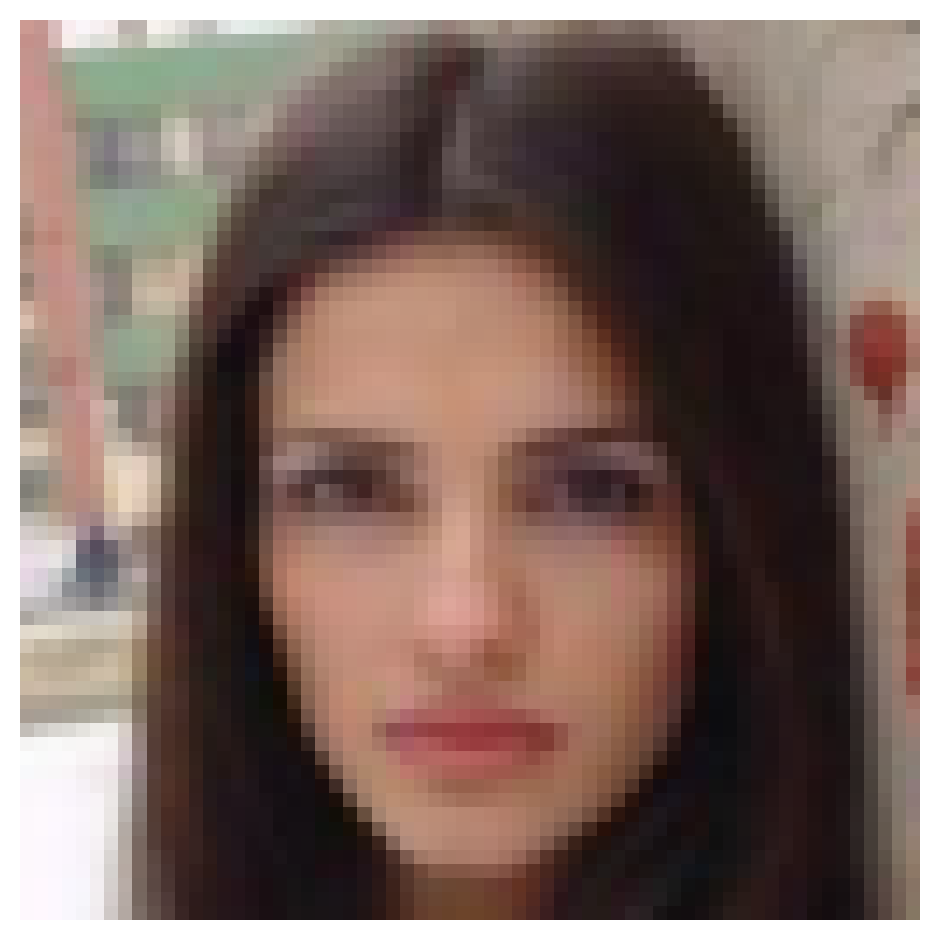

In [15]:
import matplotlib.pyplot as plt

img = train[6]
img = train[25]
print(img.shape)
plt.axis("off")
plt.imshow(img)